In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *

### Function 

In [8]:
def gaussian_func(x, *, amp:float=1.0, ave:float=0, std:float=1.0):
    """ガウス関数
    Args:
        amp(float): 振幅
        ave(float): 平均
        std(float): 標準偏差
    Returns:
        gaussian function(float)
    """
    return amp*np.exp(-1*((x - ave)/2*std)**2)

In [9]:
def rmse(true:list, prediction:list) -> np.ndarray:
  return np.sqrt(mean_squared_error(true, prediction))

In [10]:
def csv2list(path:str) -> np.ndarray:
  return np.genfromtxt(path, delimiter=",")

## LORENZ(1963) MODEL

### 0 step. Private package 

In [4]:
def _accuracy_rmse_func(true_list:list, asses_list:list, num_elem:int) -> list:
  """RMSEリストの作成
  Args:
      true_list(list): 今回の実験の真値
      asses_list(list): 真値との差を図りたいリスト
      num_elem(int): 真値との差を図りたい変数の数
  Returns:
      rmse_list(list): タイムステップ別に分けたrmse
  Note:
    シミュレーション値, データ同化値と観測値では, RMSEのタイムリストや変数の数が違うので注意。
  """
  rmse_list  = []
  time_range = len(true_list[0])
  
  for i_num in range(time_range):
    rmse_true_list , rmse_asses_list= [], []
    for i_elem in range(num_elem):
      rmse_true_list.append(true_list[i_elem][i_num])
      rmse_asses_list.append(asses_list[i_elem][i_num])
    _rmse = rmse(rmse_true_list, rmse_asses_list)
    rmse_list.append(_rmse)
  
  return rmse_list

In [5]:
def _enkf_pathset(mem:int, method_num:int, *, outdir:str='./output/lorenz63/') -> str:
  """EnKFのPATH設定

  Args:
      mem(int): EnKFのメンバー数
      method_num(int): 0はPO法、1はSRF法

  Keyword Arguments:
      outdir(str): PATHの大元設定。変更なければ引数に加えなくて良い。 (default: {'./output/lorenz63'})

  Returns:
      enkf_data_path(str):  enkfのデータPATH
      enkf_errcov_path(str):  enkfの誤差共分散データPATH
  """
  enkf_method = ['PO', 'SRF']
  enkf_data_path = outdir+'EnKF_'+str(mem)+'m_'+enkf_method[method_num]+'.csv'
  enkf_errcov_path = outdir+'errcov_EnKF_'+str(mem)+'m_'+enkf_method[method_num]+'.csv'
  return enkf_data_path, enkf_errcov_path

In [6]:
def _df2list(Dataframe:pd.core.frame.DataFrame, *index_wrd:tuple) -> list:
    """pandasフレームをリスト化

    Args:
      Dataframe(pd.core.frame.DataFrame): リスト化したいデータフレーム
      index_wrd(tuple): 抽出したいコラム名

    Returns:
      index_list(list): pandasフレームを指定されたコラム名で抽出したリスト
    """
    index_list = []
    for i_index in index_wrd:
      index_list.append(Dataframe[i_index].tolist())
    return index_list

### 1step. Prepare Data SET

In [5]:
outdir = './output/lorenz63/'
path_kf, path_kf_errcov = outdir+'KF.csv', outdir+'errcov_KF.csv'

In [8]:
df  = pd.read_csv(path_kf, sep=',', comment='#', skiprows=2)
time_list = _df2list(df, ' timestep')[0]
true_list = _df2list(df, ' x_true', ' y_true', ' z_true')
undef = -999.e0
    
# obs. list
obs = df.loc[ :, [' timestep', ' x_true', ' y_true', ' z_true', ' x_obs', ' y_obs', ' z_obs']]
obs = obs[obs[' x_obs'] != undef]
obs_time_list = _df2list(obs, ' timestep')[0]
obs_true_list = _df2list(obs, ' x_true', ' y_true', ' z_true')
obs_list      = _df2list(obs, ' x_obs', ' y_obs', ' z_obs')
    
# sim. list
sim_list  = _df2list(df, ' x_sim', ' y_sim', ' z_sim')
da_list   = _df2list(df, ' x_anl', ' y_anl', ' z_anl')

### 2nd step. RMSE calculate

In [9]:
num_sim_elem, num_obs_elem = 3, 3
rmse_sim = _accuracy_rmse_func(true_list, sim_list, num_sim_elem)
rmse_kf    = _accuracy_rmse_func(true_list, da_list, num_sim_elem)
rmse_obs = _accuracy_rmse_func(obs_true_list, obs_list, num_obs_elem)

### 3rd step. Result

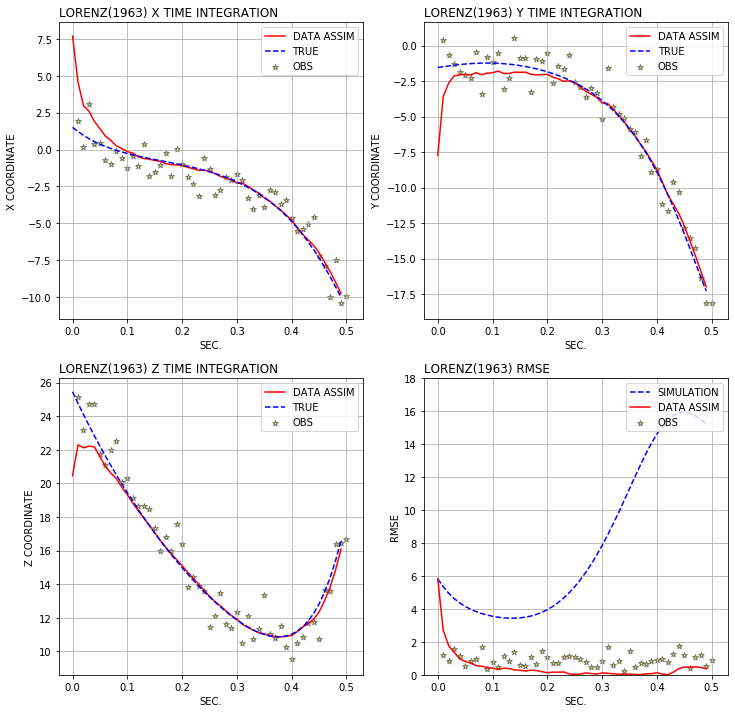

In [10]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

# set parm
time_length = 50

# ax[0,0] = x
x_ax = ax[0,0]
x_ax.plot(time_list[0:time_length], da_list[0][0:time_length], color='r', ls='-', label='DATA ASSIM')
x_ax.plot(time_list[0:time_length], true_list[0][0:time_length], color='b', ls='--', label='TRUE')
x_ax.scatter(obs_time_list[0:time_length], obs_list[0][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
x_ax.set_xlabel('SEC.')
x_ax.set_ylabel('X COORDINATE')
x_ax.set_title('LORENZ(1963) X TIME INTEGRATION', loc='left')
x_ax.grid()
x_ax.legend(loc='upper right')


# ax[0,1] = y
y_ax = ax[0,1]
y_ax.plot(time_list[0:time_length], da_list[1][0:time_length], color='r', ls='-', label='DATA ASSIM')
y_ax.plot(time_list[0:time_length], true_list[1][0:time_length], color='b', ls='--', label='TRUE')
y_ax.scatter(obs_time_list[0:time_length], obs_list[1][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
y_ax.set_xlabel('SEC.')
y_ax.set_ylabel('Y COORDINATE')
y_ax.set_title('LORENZ(1963) Y TIME INTEGRATION', loc='left')
y_ax.grid()
y_ax.legend(loc='upper right')


# ax[1,0] = z
z_ax = ax[1,0]
z_ax.plot(time_list[0:time_length], da_list[2][0:time_length], color='r', ls='-', label='DATA ASSIM')
z_ax.plot(time_list[0:time_length], true_list[2][0:time_length], color='b', ls='--', label='TRUE')
z_ax.scatter(obs_time_list[0:time_length], obs_list[2][0:time_length],  marker='*', color='y', edgecolor='k', s=35, alpha=0.5, label='OBS')
z_ax.set_xlabel('SEC.')
z_ax.set_ylabel('Z COORDINATE')
z_ax.set_title('LORENZ(1963) Z TIME INTEGRATION', loc='left')
z_ax.grid()
z_ax.legend(loc='upper right')


#ax[1,1] = RMSE
rmse_ax = ax[1,1]
rmse_ax.plot(time_list[0:time_length], rmse_sim[0:time_length], ls="--", color='b', label='SIMULATION')
rmse_ax.plot(time_list[0:time_length], rmse_kf[0:time_length], ls="-", color='r', label='DATA ASSIM')
rmse_ax.scatter(obs_time_list[0:time_length], rmse_obs[0:time_length], marker='*', color='y', s=35, alpha=0.5, edgecolor='k', label='OBS')
rmse_ax.set_xlabel('SEC.')
rmse_ax.set_ylabel('RMSE')
rmse_ax.set_ylim(0, 18)
rmse_ax.set_title('LORENZ(1963) RMSE', loc='left')
rmse_ax.grid()
rmse_ax.legend(loc='upper right')


## LORENZ(1996) MODEL

### 1 step. Prepare Data SET

In [124]:
# (1) dimension
obs_xintv = 1
obs_tintv = 1
day_tintv = 4
init_step = 1
nx = 40

# obs
ny = int(nx/obs_xintv)
#ny = 1

stepday = 40
timestep = stepday*day_tintv

timeshape = init_step + timestep
obs_timeshape =  int(timestep/obs_tintv)

# (2) PATH setting
# >> The three file names below do not change in any way.
outdir = './output/lorenz96/'
true_path = outdir + 'normal_true_score_' + str(nx) + 'ndim.csv'
sim_path = outdir + 'normal_sim_score_' + str(nx) + 'ndim.csv'
obs_path = outdir + 'normal_obs_score_' + str(nx) + 'ndim.csv'

""" KF data set """
path_kf = outdir + 'normal_KF_anl_score_' + str(nx) + 'ndim.csv'
path_kf_anlinc = outdir + 'normal_KF_anlinc_' + str(nx) + 'ndim.csv'
path_kf_errcov = outdir + 'normal_KF_errcov_' + str(nx) + 'ndim.csv'

"""Ensemble KF data set (basic is EnSRF.) """
mems = 10
path_enkf = outdir + 'normal_EnKF' + str(mems) + 'm_anl_score_' + str(nx) + 'ndim.csv'
path_kf = outdir + 'normal_EnKF' + str(mems) + 'm_anl_score_' + str(nx) + 'ndim_loc_.csv'
path_enkf_anlinc = outdir + 'normal_EnKF' + str(mems) + 'm_anlinc_' + str(nx) + 'ndim.csv'
path_kf_anlinc = outdir + 'normal_EnKF' + str(mems) + 'm_anlinc_' + str(nx) + 'ndim_loc.csv'
path_enkf_errcov = outdir + 'normal_EnKF' + str(mems) + 'm_errcov_' + str(nx) + 'ndim.csv'
path_kf_errcov = outdir + 'normal_EnKF' + str(mems) + 'm_errcov_' + str(nx) + 'ndim_loc.csv'

In [125]:
true_score = csv2list(true_path).reshape(timeshape, nx)
sim_score = csv2list(sim_path).reshape(timeshape, nx)
obs_score = csv2list(obs_path).reshape(obs_timeshape, ny)

In [126]:
num_kind = 1
kf_anl_score = csv2list(path_kf).reshape(timeshape, nx)
kf_anlinc_score = csv2list(path_kf_anlinc).reshape(obs_timeshape, nx)
kf_errcov_score = csv2list(path_kf_errcov).reshape(obs_timeshape,nx,nx)

### 2nd step. RMSE

In [127]:
rmse_anl_list = [[]* i for i in range(num_kind)]
rmse_sim_list, rmse_obs_list = [], []

for _it in range(timeshape):
    rmse_sim = rmse(true_score[_it], sim_score[_it])
    rmse_kf = rmse(true_score[_it], kf_anl_score[_it])
    rmse_sim_list.append(rmse_sim)
    rmse_anl_list[0].append(rmse_kf)

for _it in range(obs_timeshape):
    obs_true_score = []
    for _obs in range(0, nx, obs_xintv):
        obs_true_score.append(true_score[_it*obs_tintv+obs_tintv][_obs])
    rmse_obs = rmse(obs_true_score, obs_score[_it])
    rmse_obs_list.append(rmse_obs)

### 3rd step. Result

In [208]:
# set parm@TRUE&SIM&ANL
x_coord = np.arange(nx)
y_coord = np.arange(timeshape)
levels  = np.arange(-8.0, 8.0, 0.05)
cmap = plt.get_cmap('PiYG')

# set parm@INCREMENT
x_coord = np.arange(nx)
inc_y_coord = np.arange(obs_timeshape)
inc_levels  = np.arange(-1.0, 1.0, 0.1)
inc_cmap = plt.get_cmap('bwr')

### 3.1 Hovmeller

Text(0.0, 1.0, 'LORENZ(1996) TRUE - DATA ASSIM')

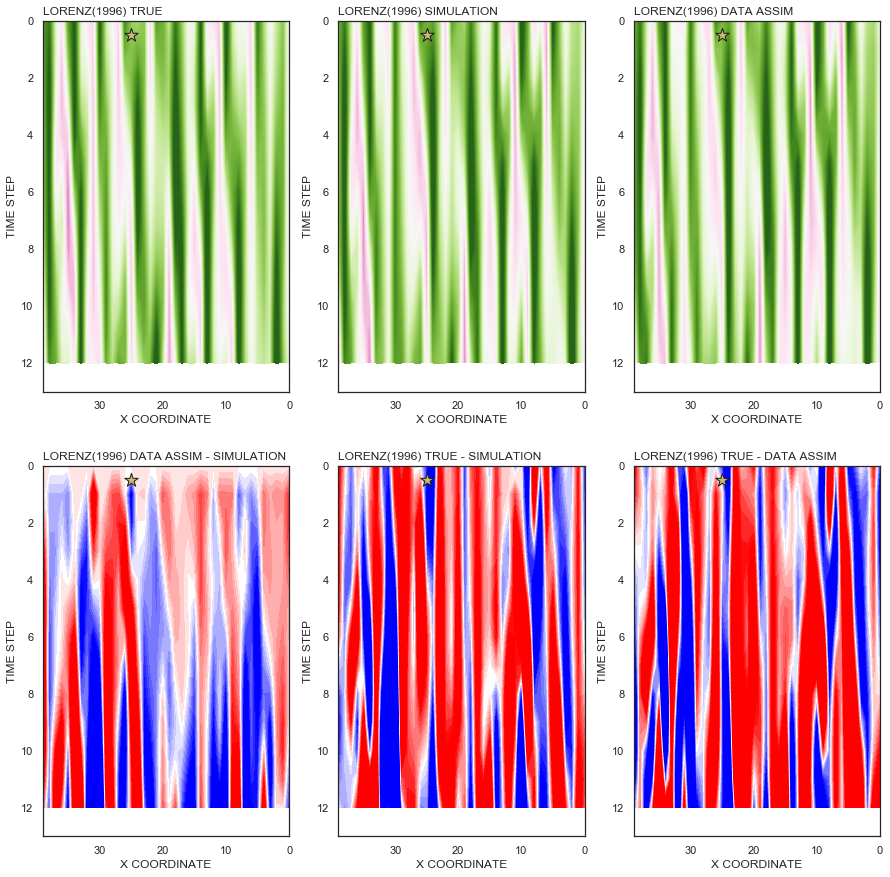

In [209]:
fig, ax = plt.subplots(2,3, figsize=(15,15))
obs_point = 25

# ax[0,0] = TRUE HOVMELLOR
true_hov= ax[0,0]
_cbar = true_hov.contourf(x_coord, y_coord, true_score, levels, cmap=cmap, extend='both')
true_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
true_hov.set_xlabel('X COORDINATE')
true_hov.set_ylabel('TIME STEP')
true_hov.set_ylim(timeshape,0)
true_hov.set_xlim(nx-1,0)
true_hov.set_title('LORENZ(1996) TRUE', loc='left')

# ax[0,1] = SIMLATION HOVMELLOR
sim_hov= ax[0,1]
sim_hov.contourf(x_coord, y_coord, sim_score, levels, cmap=cmap, extend='both')
sim_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
sim_hov.set_xlabel('X COORDINATE')
sim_hov.set_ylabel('TIME STEP')
sim_hov.set_ylim(timeshape,0)
sim_hov.set_xlim(nx-1,0)
sim_hov.set_title('LORENZ(1996) SIMULATION', loc='left')

# ax[1,0] = DATA ASSIM HOVMELLOR
anl_hov= ax[0,2]
anl_hov.contourf(x_coord, y_coord, kf_anl_score, levels, cmap=cmap, extend='both')
#anl_hov.contourf(x_coord, y_coord, kf_anl_score-sim_score, inc_levels, cmap=cmap, extend='both')
anl_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
anl_hov.set_xlabel('X COORDINATE')
anl_hov.set_ylabel('TIME STEP')
anl_hov.set_ylim(timeshape,0)
anl_hov.set_xlim(nx-1,0)
anl_hov.set_title('LORENZ(1996) DATA ASSIM', loc='left')

#ax[1,0] DATA ANL - SIMULAITION
anlinc_hov= ax[1,0]
anlinc_hov.contourf(x_coord, y_coord, kf_anl_score-sim_score, inc_levels, cmap=inc_cmap, extend='both')
anlinc_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
anlinc_hov.set_xlabel('X COORDINATE')
anlinc_hov.set_ylabel('TIME STEP')
anlinc_hov.set_ylim(timeshape,0)
anlinc_hov.set_xlim(nx-1,0)
anlinc_hov.set_title('LORENZ(1996) DATA ASSIM - SIMULATION', loc='left')

#ax[1,1] TRUE - SIMULAITION
simdiff_hov= ax[1,1]
simdiff_hov.contourf(x_coord, y_coord, true_score-sim_score, inc_levels, cmap=inc_cmap, extend='both')
simdiff_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
simdiff_hov.set_xlabel('X COORDINATE')
simdiff_hov.set_ylabel('TIME STEP')
simdiff_hov.set_ylim(timeshape,0)
simdiff_hov.set_xlim(nx-1,0)
simdiff_hov.set_title('LORENZ(1996) TRUE - SIMULATION', loc='left')

#ax[1,1] TRUE - DATA ASSIM
anldiff_hov= ax[1,2]
anldiff_hov.contourf(x_coord, y_coord, true_score-kf_anl_score, inc_levels, cmap=inc_cmap, extend='both')
anldiff_hov.scatter(obs_point, 0.5, marker='*',  s=200, alpha=1.0, color='y', edgecolor='k', label='OBS')
anldiff_hov.set_xlabel('X COORDINATE')
anldiff_hov.set_ylabel('TIME STEP')
anldiff_hov.set_ylim(timeshape,0)
anldiff_hov.set_xlim(nx-1,0)
anldiff_hov.set_title('LORENZ(1996) TRUE - DATA ASSIM', loc='left')

### 3.2 Trajectory

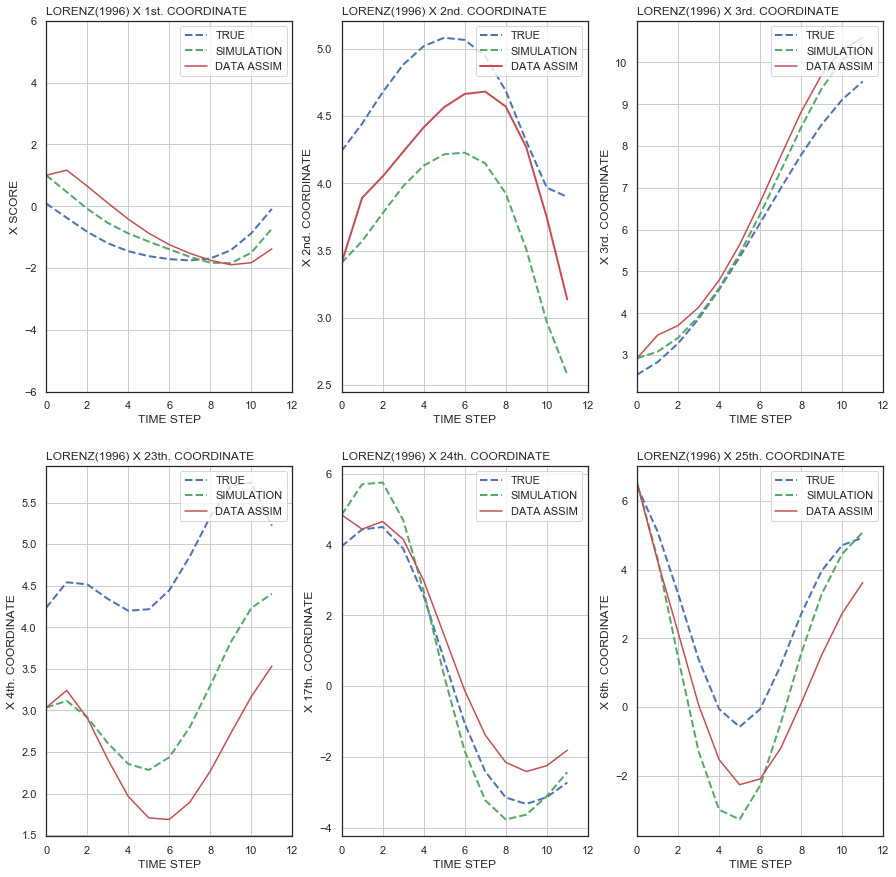

In [214]:
fig, ax = plt.subplots(2, 3, figsize=(15,15))
time_length = 12
x_coord = np.arange(time_length)
obs_x_coord = np.arange(1,time_length, obs_tintv)

# ax[0,0] = X 1st. COORDINATE
first= ax[0,0]
first.set_xlabel('TIME STEP')
first.set_ylabel('X SCORE')
first.set_xlim(0, time_length)
first.set_ylim(-6, 6)
first.set_title('LORENZ(1996) X 1st. COORDINATE', loc='left')
first.plot(x_coord, true_score[0:time_length, 0], lw=2.0, ls="--", color='b', label='TRUE')
first.plot(x_coord, sim_score[0:time_length, 0], lw=2.0, ls="--", color='g', label='SIMULATION')
first.plot(x_coord, kf_anl_score[0:time_length, 0], ls="-", color='r', label='DATA ASSIM')
#first.scatter(obs_x_coord, obs_score[0:time_length-1, 0], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
first.grid()
first.legend(loc='upper right')

# ax[0,1] = X 2nd. COORDINATE
sec= ax[0,1]
sec.set_xlabel('TIME STEP')
sec.set_ylabel('X 2nd. COORDINATE')
sec.set_xlim(0, time_length)
#sec.set_ylim(-6, 6)
sec.set_title('LORENZ(1996) X 2nd. COORDINATE', loc='left')
sec.plot(x_coord, true_score[0:time_length, 1], lw=2.0, ls="--", color='b', label='TRUE')
sec.plot(x_coord, sim_score[0:time_length, 1], lw=2.0, ls="--", color='g', label='SIMULATION')
sec.plot(x_coord, kf_anl_score[0:time_length, 1], lw=2.0, ls="-", color='r', label='DATA ASSIM')
#sec.scatter(obs_x_coord, obs_score[0:time_length-1, 1], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
sec.grid()
sec.legend(loc='upper right')

# ax[0,2] = X 3rd. COORDINATE
third= ax[0, 2]
third.set_xlabel('TIME STEP')
third.set_ylabel('X 3rd. COORDINATE')
third.set_xlim(0, time_length)
#third.set_ylim(-6, 6)
third.set_title('LORENZ(1996) X 3rd. COORDINATE', loc='left')
third.plot(x_coord, true_score[0:time_length, 2], lw=2.0, ls="--", color='b', label='TRUE')
third.plot(x_coord, sim_score[0:time_length, 2], lw=2.0, ls="--", color='g', label='SIMULATION')
third.plot(x_coord, kf_anl_score[0:time_length, 2], ls="-", color='r', label='DATA ASSIM')
#third.scatter(obs_x_coord, obs_score[0:time_length-1, 2], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
third.grid()
third.legend(loc='upper right')

# ax[1,0] = X 4th. COORDINATE
first= ax[1,0]
first.set_xlabel('TIME STEP')
first.set_ylabel('X 4th. COORDINATE')
first.set_xlim(0, time_length)
#first.set_ylim(-6, 6)
first.set_title('LORENZ(1996) X 23th. COORDINATE', loc='left')
first.plot(x_coord, true_score[0:time_length, obs_point-2], lw=2.0, ls="--", color='b', label='TRUE')
first.plot(x_coord, sim_score[0:time_length, obs_point-2], lw=2.0, ls="--", color='g', label='SIMULATION')
first.plot(x_coord, kf_anl_score[0:time_length, obs_point-2], ls="-", color='r', label='DATA ASSIM')
#first.scatter(obs_x_coord, obs_score[0:time_length-1, 3], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
first.grid()
first.legend(loc='upper right')

# ax[1,1] = X 5th. COORDINATE
sec= ax[1,1]
sec.set_xlabel('TIME STEP')
sec.set_ylabel('X 17th. COORDINATE')
sec.set_xlim(0, time_length)
#sec.set_ylim(-6, 6)
sec.set_title('LORENZ(1996) X 24th. COORDINATE', loc='left')
sec.plot(x_coord, true_score[0:time_length, obs_point], lw=2.0, ls="--", color='b', label='TRUE')
sec.plot(x_coord, sim_score[0:time_length, obs_point], lw=2.0, ls="--", color='g', label='SIMULATION')
sec.plot(x_coord, kf_anl_score[0:time_length, obs_point], ls="-", color='r', label='DATA ASSIM')
#sec.scatter(obs_x_coord, obs_score[0:time_length-1, 4], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
sec.grid()
sec.legend(loc='upper right')

# ax[1,2] = X 6th. COORDINATE
third= ax[1, 2]
third.set_xlabel('TIME STEP')
third.set_ylabel('X 6th. COORDINATE')
third.set_xlim(0, time_length)
#third.set_ylim(-6, 6)
third.set_title('LORENZ(1996) X 25th. COORDINATE', loc='left')
third.plot(x_coord, true_score[0:time_length, obs_point+1], lw=2.0, ls="--", color='b', label='TRUE')
third.plot(x_coord, sim_score[0:time_length, obs_point+1], lw=2.0, ls="--", color='g', label='SIMULATION')
third.plot(x_coord, kf_anl_score[0:time_length, obs_point+1], ls="-", color='r', label='DATA ASSIM')
#third.scatter(obs_x_coord, obs_score[0:time_length-1, 5], marker='*',  s=35, alpha=0.5, edgecolor='k', label='OBS')
third.grid()
third.legend(loc='upper right')


### 4th step. RMSE Result

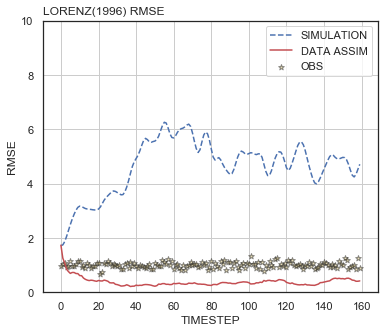

In [128]:
fig, ax = plt.subplots(figsize=(6, 5))

# set parm
time_list, obs_time_list = np.arange(timeshape), np.arange(obs_timeshape)
time_length = 160

rmse_draw = ax
rmse_draw.plot(time_list[0:time_length], rmse_sim_list[0:time_length], ls="--", color='b', label='SIMULATION')
rmse_draw.plot(time_list[0:time_length], rmse_anl_list[0][0:time_length], ls="-", color='r', label='DATA ASSIM')
rmse_draw.scatter(obs_time_list[0:time_length], rmse_obs_list[0:time_length], marker='*', color='y', s=35, alpha=0.5, edgecolor='k', label='OBS')
rmse_draw.set_xlabel('TIMESTEP')
rmse_draw.set_ylabel('RMSE')
rmse_draw.set_title('LORENZ(1996) RMSE', loc='left')
rmse_draw.set_ylim(0,10.0)
rmse_draw.grid()
rmse_draw.legend(loc='upper right')

### 5th step. error covariance
Prepare kf_anlinc_score = csv2list(path_kf_anlinc).reshape(obs_timeshape, nx)

In [115]:
x_coord = np.arange(nx)
time_length = 160
center_grd = 20
center_list = []
center_list = kf_anlinc_score[50:time_length, center_grd]

In [116]:
cross_corrlist = []
for _grd in range(nx):
    opt_list = kf_anlinc_score[50:time_length, _grd]
    corr, _ = np.corrcoef(center_list, opt_list)
    cross_corrlist.append(corr[1])

### 5.1 Prepare gaussan distribution

In [117]:
gaussian_list = []
std_list = np.arange(0.05, 2.0, 0.05)

In [118]:
for _ in std_list:
    y_gauss = gaussian_func(x_coord, amp=1.0, ave=20, std=_)
    gaussian_list.append(y_gauss)

In [119]:
rmse_list = []
for _ in gaussian_list:
    rmse_list.append(rmse(cross_corrlist, _))

In [120]:
least_case = np.argmin(rmse_list)
least_rmse = min(rmse_list)
y_gauss = gaussian_list[least_case]

### 5.2 cross section covariance

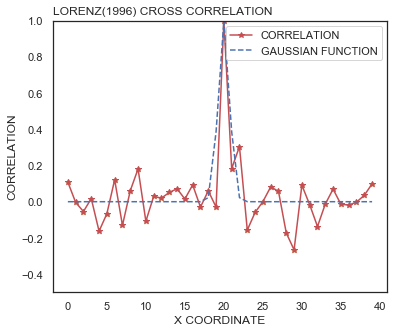

In [121]:
fig, ax = plt.subplots(figsize=(6, 5))

cross_corrdraw = ax
cross_corrdraw.scatter(x_coord, cross_corrlist, marker='*', color='y')
cross_corrdraw.plot(x_coord, cross_corrlist, marker='*', color='r', label='CORRELATION')
cross_corrdraw.plot(x_coord, y_gauss, ls='--', color='b', label='GAUSSIAN FUNCTION')
cross_corrdraw.set_xlabel('X COORDINATE')
cross_corrdraw.set_ylabel('CORRELATION')
cross_corrdraw.set_title('LORENZ(1996) CROSS CORRELATION', loc='left')
cross_corrdraw.set_ylim(-0.5,1.0)
cross_corrdraw.legend(loc='upper right')

### 5.3 error covariance matrix

In [122]:
opt_time =  30
errcov_mtx = kf_errcov_score[opt_time]

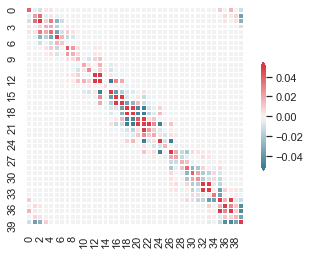

In [123]:
fig, ax = plt.subplots()

errcov_draw = ax
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(style='white')
sns.heatmap(
    data=errcov_mtx, cmap=cmap, 
    vmax=0.05, vmin=-0.05, center=0,
    square=True, linewidths=.5, 
    cbar_kws={"shrink": .5, "extend": 'both'},
)

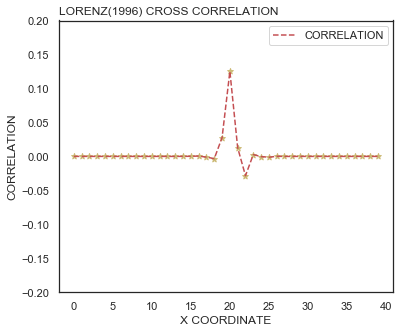

In [104]:
fig, ax = plt.subplots(figsize=(6, 5))

cross_corrdraw = ax
cross_corrdraw.scatter(x_coord, errcov_mtx[20], marker='*', color='y')
cross_corrdraw.plot(x_coord, errcov_mtx[20], ls='--', color='r', label='CORRELATION')
cross_corrdraw.set_xlabel('X COORDINATE')
cross_corrdraw.set_ylabel('CORRELATION')
cross_corrdraw.set_title('LORENZ(1996) CROSS CORRELATION', loc='left')
cross_corrdraw.set_ylim(-0.2,0.2)
cross_corrdraw.legend(loc='upper right')

### 6th step. lorenz and emanuel(1998)

In [28]:
import glob

In [69]:
indir = '/Users/toyo/Terminal/DA_basic/output/lorenz96_and_emanuel_exp/'
true_path = indir + 'normal_true_score_40ndim.csv'
obs_path = indir + 'normal_obs_score_40ndim.csv'
anl_pathlist =[]
anl_pathlist = glob.glob(indir + '/normal_EnKF10m_anl_score_40ndim_alpha_*d0_shchur_prm*.csv')

In [70]:
true_data = csv2list(true_path).reshape(6001, 40)
obs_data = csv2list(obs_path).reshape(6000, 40)

In [43]:
data = []
for ifile in anl_pathlist:
    anl_score = csv2list(ifile).reshape(6001,40)
    data.append(anl_score)

In [52]:
rmse_anl_list = [[]* i for i in range(100)]

for _file in range(len(data)):
    for _it in range(6001):
        _rmse = rmse(true_data[_it], data[_file][_it])
        rmse_anl_list[_file].append(_rmse)

*** RMSE for lorenz and emanuel(1996)

In [35]:
rmse_list = []
for _it in range(len(data)):
    rmse_score = rmse(data[_it][300:], true_data[300:])
    rmse_list.append(rmse_score)

In [60]:
len(rmse_anl_list[0])

6001

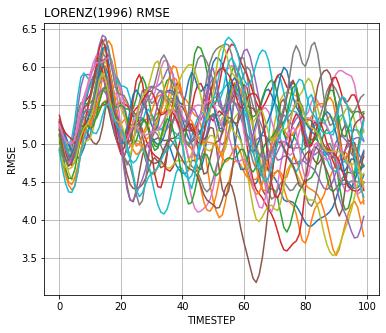

In [67]:
fig, ax = plt.subplots(figsize=(6, 5))

# set parm
time_list = np.arange(6001)
time_length = 100

rmse_draw = ax
#for _file in range(len(data)):
for _file in range(30):
    rmse_draw.plot(time_list[0:time_length], rmse_anl_list[_file][0:time_length])
    
rmse_draw.set_xlabel('TIMESTEP')
rmse_draw.set_ylabel('RMSE')
rmse_draw.set_title('LORENZ(1996) RMSE', loc='left')
rmse_draw.grid()